##Introduction

In this notebook, we implement the technique of chain-of-thought prompting according to Wei et al. in 2022[1]. This is a step-by-step process to guide language models by guiding the model into solving a problem as a human being. By decomposing questions into smaller, easily processable parts, the model improves on tasks that need more critical thinking. We also used few-shot prompting in the paper, which means we gave the model only a few examples to learn from. This helps us see how well the model can think with only a little bit of guidance.


##Our experiment setup
models used: GPT-4o, GPT-4o-mini[2] (https://platform.openai.com/docs/models) \\
prompting techniques: normal few-shot prompt, chain-of-thought few-shot prompt \\
datasets: GSM8K[3] and CSQA[4] (We conducted the experiment with 100 questions from each dataset due to limitations in computational resources.) \\

##Detailed explanations

Instead of using the models that were used in the paper, we decided to use gpt-4o(2024-08-06) and gpt-4o-mini(2024-07-18). The reason was that:
1. There is no need to replicate the exact experiments from the paper.
2. These newer models, released two years after the paper's publication, present an opportunity to explore whether chain-of-thought prompting continues to enhance performance and accuracy in more recent AI developments.
3. By using both models we can investigate whether the number of parameters within the models affects the effectiveness of chain-of-thought prompting.


Testing language models on the GSM8K and CSQA datasets helps us understand how well the models solve different kinds of problems. GSM8K involves math problems that require the model to think through steps like a human would, which is excellent for seeing how well it handles complex calculations. CSQA focuses on common sense and understanding everyday situations. It can test the model's ability on common sense questions. By using both datasets, we can get a complete picture of what the models do well and where they might struggle.



##Our Code:

In [ ]:
!pip install -q openai
!pip install datasets
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 w

###Running the test

In [ ]:
# Import necessary libraries
import openai
from openai import OpenAI
import os
from datasets import load_dataset
import re
from google.colab import userdata



# Set the environment variable for OpenAI API key using the value retrieved from Google Colab's userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
# Initialize the OpenAI object
openai = OpenAI()


# Load the GSM8K dataset from Hugging Face https://huggingface.co/datasets/openai/gsm8k
ds_gsm8k = load_dataset("openai/gsm8k", "main")
# Load the CSQA dataset from Hugging Face https://huggingface.co/datasets/skrishna/CSQA_preprocessed
ds_csqa = load_dataset("skrishna/CSQA_preprocessed")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/781 [00:00<?, ?B/s]

(…)-00000-of-00001-9a3e117974f3df72.parquet:   0%|          | 0.00/2.17M [00:00<?, ?B/s]

(…)-00000-of-00001-88293287a87edde2.parquet:   0%|          | 0.00/275k [00:00<?, ?B/s]

(…)-00000-of-00001-8a79b0575687f4c8.parquet:   0%|          | 0.00/260k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9741 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1221 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1140 [00:00<?, ? examples/s]

In [ ]:
def extract_answer(text, pattern):
    """
    Extract the last occurrence of a specified pattern from a given text.

    Args:
    text (str): The string from which to extract the answer.
    pattern (str): The regular expression pattern used to identify the answer.

    Returns:
    str or None: The last occurrence of the matched pattern with any trailing periods removed,
                 or None if no matches are found.

    Example:
    extract_answer("The answer is B The answer is A", r"[tT]he answer is [\(]?(\w)[\)]?")
    # This would return 'A'
    """
    # Use re.findall to get all matches of the pattern
    matches = re.findall(pattern, text)
    # Check if there are any matches
    if matches:
        # Return the last match and remove any periods
        return matches[-1].replace('.', '')
    # Return None if no matches are found
    return None
#print(extract_answer("The answer is B The answer is A. the answer is d the answer is f", r"[tT]he answer is [\(]?(\w)[\)]?"))

In [ ]:
# Math question and answer prompt set
math_prompt = [
    {"question": "There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there will be 21 trees. How many trees did the grove workers plant today?",
     "answer": "There are 15 trees originally. Then there were 21 trees after some more were planted. So there must have been 21 - 15 = 6. The answer is 6."},
    {"question": "If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?",
     "answer": "There are originally 3 cars. 2 more cars arrive. 3 + 2 = 5. The answer is 5."},
    {"question": "Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?",
     "answer": "Originally, Leah had 32 chocolates. Her sister had 42. So in total they had 32 + 42 = 74. After eating 35, they had 74 - 35 = 39. The answer is 39."},
    {"question": "Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did Jason give to Denny?",
     "answer": "Jason started with 20 lollipops. Then he had 12 after giving some to Denny. So he gave Denny 20 - 12 = 8. The answer is 8."},
    {"question": "Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does he have now?",
     "answer": "Shawn started with 5 toys. If he got 2 toys each from his mom and dad, then that is 4 more toys. 5 + 4 = 9. The answer is 9."},
    {"question": "There were nine computers in the server room. Five more computers were installed each day, from Monday to Thursday. How many computers are now in the server room?",
     "answer": "There were originally 9 computers. For each of 4 days, 5 more computers were added. So 5 * 4 = 20 computers were added. 9 + 20 is 29. The answer is 29."},
    {"question": "Michael had 58 golf balls. On Tuesday, he lost 23 golf balls. On Wednesday, he lost 2 more. How many golf balls did he have at the end of Wednesday?",
     "answer": "Michael started with 58 golf balls. After losing 23 on Tuesday, he had 58 - 23 = 35. After losing 2 more, he had 35 - 2 = 33 golf balls. The answer is 33."},
    {"question": "Olivia has $23. She bought five bagels for $3 each. How much money does she have left?",
     "answer": "Olivia had 23 dollars. 5 bagels for 3 dollars each will be 5 x 3 = 15 dollars. So she has 23 - 15 dollars left. 23 - 15 is 8. The answer is 8."}
]

# CSQA (Commonsense Question Answering) prompt set
csqa_prompt = [
    {"question": "What do people use to absorb extra ink from a fountain pen? Answer Choices: (a) shirt pocket (b) calligrapher’s hand (c) inkwell (d) desk drawer (e) blotter",
     "answer": "The answer must be an item that can absorb ink. Of the above choices, only blotters are used to absorb ink. So the answer is (e)."},
    {"question": "What home entertainment equipment requires cable? Answer Choices: (a) radio shack (b) substation (c) television (d) cabinet",
     "answer": "The answer must require cable. Of the above choices, only television requires cable. So the answer is (c)."},
    {"question": "The fox walked from the city into the forest, what was it looking for? Answer Choices: (a) pretty flowers (b) hen house (c) natural habitat (d) storybook",
     "answer": "The answer must be something in the forest. Of the above choices, only natural habitat is in the forest. So the answer is (b)."},
    {"question": "Sammy wanted to go to where the people were. Where might he go? Answer Choices: (a) populated areas (b) race track (c) desert (d) apartment (e) roadblock",
     "answer": "The answer must be a place with a lot of people. Of the above choices, only populated areas have a lot of people. So the answer is (a)."},
    {"question": "Where do you put your grapes just before checking out? Answer Choices: (a) mouth (b) grocery cart (c) super market (d) fruit basket (e) fruit market",
     "answer": "The answer should be the place where grocery items are placed before checking out. Of the above choices, grocery cart makes the most sense for holding grocery items. So the answer is (b)."},
    {"question": "Google Maps and other highway and street GPS services have replaced what? Answer Choices: (a) united states (b) mexico (c) countryside (d) atlas",
     "answer": "The answer must be something that used to do what Google Maps and GPS services do, which is to give directions. Of the above choices, only atlases are used to give directions. So the answer is (d)."},
    {"question": "Before getting a divorce, what did the wife feel who was doing all the work? Answer Choices: (a) harder (b) anguish (c) bitterness (d) tears (e) sadness",
     "answer": "The answer should be the feeling of someone getting divorced who was doing all the work. Of the above choices, the closest feeling is bitterness. So the answer is (c)."}
]


# Strings to accumulate the natural language processing (NLP) and chain of thought (CoT) prompts for the two datasets
math_prompt_np = ""
math_prompt_cot = ""
csqa_prompt_np = ""
csqa_prompt_cot = ""

# Loop to format math prompts for non-prompt and chain of thought responses
for i in range(len(math_prompt)):
  math_prompt_np += "Q: " + math_prompt[i]['question'] + "\nA: " + extract_answer(math_prompt[i]['answer'], r"([tT]he answer is [\w\s\-,\d]+[.?!]?)") + "\n\n"
  math_prompt_cot += "Q: " + math_prompt[i]['question'] + "\nA: " + math_prompt[i]['answer'] + "\n\n"

# Loop to format CSQA prompts for non-prompt and chain of thought responses
for i in range(len(csqa_prompt)):
  csqa_prompt_np += "Q: " + csqa_prompt[i]['question'] + "\nA: " + extract_answer(csqa_prompt[i]['answer'], r"([tT]he answer is [\(\w\s\-,\d]+\)[.?!]?)").replace("the answer is", "The answer is") + "\n\n"
  csqa_prompt_cot += "Q: " + csqa_prompt[i]['question'] + "\nA: " + csqa_prompt[i]['answer'] + "\n\n"


# Output the formatted strings
print("Our Prompts")
print("Normal prompt for math questions:")
print(math_prompt_np)
print("\n\nCoT prompt for math questions:")
print(math_prompt_cot)
print("\n\nNormal prompt for CSQA questions:")
print(csqa_prompt_np)
print("\n\nCoT prompt for CSQA questions:")
print(csqa_prompt_cot)


Our Prompts
Normal prompt for math questions:
Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there will be 21 trees. How many trees did the grove workers plant today?
A: The answer is 6

Q: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
A: The answer is 5

Q: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?
A: The answer is 39

Q: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did Jason give to Denny?
A: The answer is 8

Q: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does he have now?
A: The answer is 9

Q: There were nine computers in the server room. Five more computers were installed each day, from Monday to Thursday. How many computers are now in the server room?
A: The answer is 29

Q: Michael had 58 golf balls

In [ ]:
def get_chat_completion(model, dataset, msg, cot=False):
  """
  Generates chat completions from a specified model based on the dataset and whether chain of thought is used.

  Args:
  model (str): The model identifier used for generating completions.
  dataset (str): Specifies which dataset to use, can be 'math' or 'csqa'.
  msg (str): The user's query or message for which a completion is requested.
  cot (bool, optional): Flag to determine if chain of thought should be used. Defaults to False.

  Returns:
  Response: Returns the model's chat completion based on the inputs.
  """

  # Determine the appropriate prompts and development message based on dataset and CoT usage
  if dataset == "math":
    # Select the prompt set for the math dataset
    if cot:
      message = math_prompt_cot
    else:
      message = math_prompt_np
    # Developer message guiding how answers should be formatted for the math dataset
    dev_msg = "You are a helpful math assistant. Please write your answer in 'The answer is ...' format. Please do not put any symbol (for example: '$') or commas in your answer."
  elif dataset == "csqa":
    # Select the prompt set for the CSQA dataset
    if cot:
      message = csqa_prompt_cot
    else:
      message = csqa_prompt_np
    # Developer message guiding how answers should be formatted for the CSQA dataset
    dev_msg = "You are a helpful assistant. Please write your final answer in 'The answer is ...' format. Please do not put any symbol (for example: '$') or commas in your answer. " + \
    "Please providing the letter corresponding to your choice (e.g. A, B, C, D, E, .....) as you answer. Please answer following the pattern of the given prompt by user"

  # Append the user's question to the selected message
  message += "Q: " + msg # + "\nA:"

  # Prepare the messages for API request
  messages = [
      {"role": "developer", "content": dev_msg},
      {
          "role": "user",
          "content": message
      },
  ]
  # Call the OpenAI API to generate a chat completion and return it
  return openai.chat.completions.create(model=model, messages=messages)

In [ ]:
# Initialize lists to store the extracted answers and calculated accuracies for different model configurations for GSM8K
answers_gsm8k = []
answers_gsm8k_np_4o = []
answers_gsm8k_cot_4o = []
answers_gsm8k_np_4o_mini = []
answers_gsm8k_cot_4o_mini = []

# Loop over the first 100 entries of the dataset
for i in range(100):
  # Extract the correct answers from the dataset using a regex pattern
  answers_gsm8k.append(extract_answer(ds_gsm8k['test']['answer'][i], r"#### ([-]?\d+[.?\d+]?)"))

  # Get normal prompted and chain of thought (CoT) answers from the GPT-4o model
  np_ans_4o = get_chat_completion("gpt-4o", "math", ds_gsm8k['test']['question'][i]).choices[0].message.content
  cot_ans_4o = get_chat_completion("gpt-4o", "math", ds_gsm8k['test']['question'][i], True).choices[0].message.content
  answers_gsm8k_np_4o.append(extract_answer(np_ans_4o, r"[tT]he answer is (\d+)"))
  answers_gsm8k_cot_4o.append(extract_answer(cot_ans_4o, r"[tT]he answer is (\d+)"))

  # Get normal prompted and chain of thought (CoT) answers from the GPT-4o-mini model
  np_ans_4o_mini = get_chat_completion("gpt-4o-mini", "math", ds_gsm8k['test']['question'][i]).choices[0].message.content
  cot_ans_4o_mini = get_chat_completion("gpt-4o-mini", "math", ds_gsm8k['test']['question'][i], True).choices[0].message.content
  answers_gsm8k_np_4o_mini.append(extract_answer(np_ans_4o_mini, r"[tT]he answer is (\d+)"))
  answers_gsm8k_cot_4o_mini.append(extract_answer(cot_ans_4o_mini, r"[tT]he answer is (\d+)"))

# Calculate the accuracy of each model configuration by comparing AI-generated answers to the ground truth
gsm8k_np_4o_accuracy = sum([answers_gsm8k[i] == answers_gsm8k_np_4o[i] for i in range(len(answers_gsm8k))])/len(answers_gsm8k)
gsm8k_cot_4o_accuracy = sum([answers_gsm8k[i] == answers_gsm8k_cot_4o[i] for i in range(len(answers_gsm8k))])/len(answers_gsm8k)
gsm8k_np_4o_mini_accuracy = sum([answers_gsm8k[i] == answers_gsm8k_np_4o_mini[i] for i in range(len(answers_gsm8k))])/len(answers_gsm8k)
gsm8k_cot_4o_mini_accuracy = sum([answers_gsm8k[i] == answers_gsm8k_cot_4o_mini[i] for i in range(len(answers_gsm8k))])/len(answers_gsm8k)


In [ ]:
# Initialize lists to store the extracted answers and calculated accuracies for different model configurations for CSQA
answers_csqa = []
answers_csqa_np_4o = []
answers_csqa_cot_4o = []
answers_csqa_np_4o_mini = []
answers_csqa_cot_4o_mini = []

# Loop over the first 100 entries of the dataset
for i in range(100):
  # Extract the correct answers
  answers_csqa.append(ds_csqa['validation']['answerKey'][i])

  # Get normal prompted and chain of thought (CoT) answers from the GPT-4o model
  np_ans_4o = get_chat_completion("gpt-4o", "csqa", ds_csqa['validation']['inputs'][i]).choices[0].message.content
  cot_ans_4o = get_chat_completion("gpt-4o", "csqa", ds_csqa['validation']['inputs'][i], True).choices[0].message.content
  answers_csqa_np_4o.append(extract_answer(np_ans_4o, r"[tT]he answer is [\(]?(\w)[\)]?").capitalize())
  answers_csqa_cot_4o.append(extract_answer(cot_ans_4o, r"[tT]he answer is [\(]?(\w)[\)]?").capitalize())

  # Get normal prompted and chain of thought (CoT) answers from the GPT-4o-mini model
  np_ans_4o_mini = get_chat_completion("gpt-4o-mini", "csqa", ds_csqa['validation']['inputs'][i]).choices[0].message.content
  cot_ans_4o_mini = get_chat_completion("gpt-4o-mini", "csqa", ds_csqa['validation']['inputs'][i], True).choices[0].message.content
  answers_csqa_np_4o_mini.append(extract_answer(np_ans_4o_mini, r"[tT]he answer is [\(]?(\w)[\)]?").capitalize())
  answers_csqa_cot_4o_mini.append(extract_answer(cot_ans_4o_mini, r"[tT]he answer is [\(]?(\w)[\)]?").capitalize())

# Calculate the accuracy of each model configuration by comparing AI-generated answers to the ground truth
csqa_np_4o_accuracy = sum([answers_csqa[i] == answers_csqa_np_4o[i] for i in range(len(answers_csqa))])/len(answers_csqa)
csqa_cot_4o_accuracy = sum([answers_csqa[i] == answers_csqa_cot_4o[i] for i in range(len(answers_csqa))])/len(answers_csqa)
csqa_np_4o_mini_accuracy = sum([answers_csqa[i] == answers_csqa_np_4o_mini[i] for i in range(len(answers_csqa))])/len(answers_csqa)
csqa_cot_4o_mini_accuracy = sum([answers_csqa[i] == answers_csqa_cot_4o_mini[i] for i in range(len(answers_csqa))])/len(answers_csqa)


###Accuracy plots

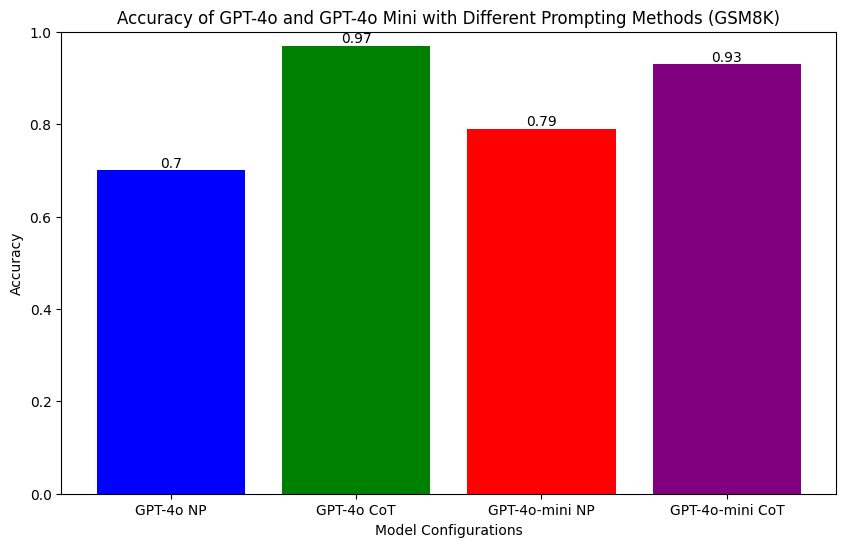

In [ ]:
import matplotlib.pyplot as plt

# Define the data
models = ['GPT-4o NP', 'GPT-4o CoT', 'GPT-4o-mini NP', 'GPT-4o-mini CoT']
accuracies = [
    gsm8k_np_4o_accuracy,
    gsm8k_cot_4o_accuracy,
    gsm8k_np_4o_mini_accuracy,
    gsm8k_cot_4o_mini_accuracy
]

# Creating the bar graph
plt.figure(figsize=(10, 6))  # Set the figure size
bars = plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple'])  # Create bars with different colors
plt.xlabel('Model Configurations')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis
plt.title('Accuracy of GPT-4o and GPT-4o Mini with Different Prompting Methods (GSM8K)')  # Title of the graph
plt.ylim(0, 1)  # Set the limits of y-axis

# Add text labels above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval}', ha='center', va='bottom')

plt.show()  # Display the graph

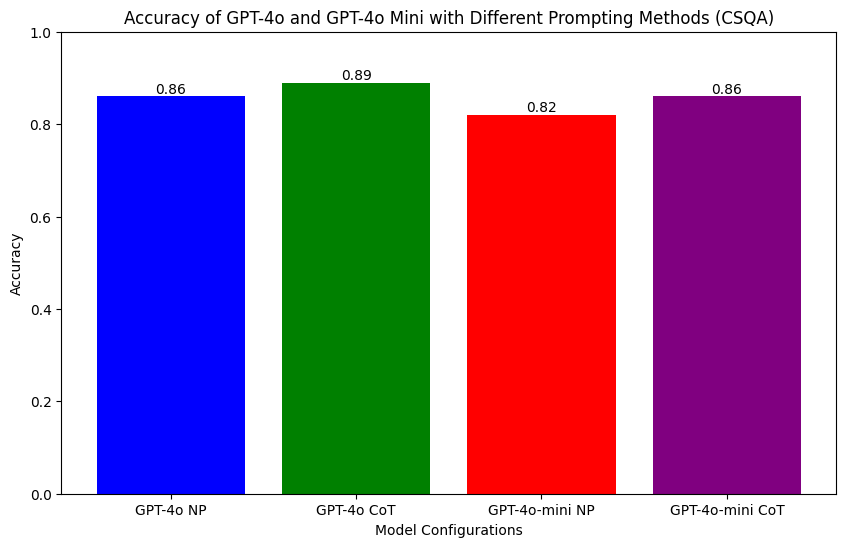

In [ ]:
# Define the labels and accuracies
labels = ['GPT-4o NP', 'GPT-4o CoT', 'GPT-4o-mini NP', 'GPT-4o-mini CoT']
accuracies = [
    csqa_np_4o_accuracy,
    csqa_cot_4o_accuracy,
    csqa_np_4o_mini_accuracy,
    csqa_cot_4o_mini_accuracy
]

# Creating the bar graph
plt.figure(figsize=(10, 6))  # Set the figure size
bars = plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple'])  # Create bars with different colors
plt.xlabel('Model Configurations')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis
plt.title('Accuracy of GPT-4o and GPT-4o Mini with Different Prompting Methods (CSQA)')  # Title of the graph
plt.ylim(0, 1)  # Set the limits of y-axis

# Add text labels above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval}', ha='center', va='bottom')

plt.show()  # Display the graph

###Sample question and answers to exanmine the different answers CoT and normal prompting.

In [ ]:
# Print question 8 from the GSM8K test dataset
print("Question:")
print(ds_gsm8k['test']['question'][7])
# Print the true answer for the question
print("Answer:")
print(ds_gsm8k['test']['answer'][7])

print('\n\n')

# Print the response generated by the GPT-4o model using chain of thought (CoT)
print('Chain of Thought:')
print(get_chat_completion("gpt-4o", "math", ds_gsm8k['test']['question'][7], True).choices[0].message.content)

# Print the response generated by the GPT-4o model using normal prompt
print('\n\nNormal prompt:')
print(get_chat_completion("gpt-4o", "math", ds_gsm8k['test']['question'][7]).choices[0].message.content)


Question:
Carla is downloading a 200 GB file. Normally she can download 2 GB/minute, but 40% of the way through the download, Windows forces a restart to install updates, which takes 20 minutes. Then Carla has to restart the download from the beginning. How load does it take to download the file?
Answer:
First find how many gigabytes are in 40% of the file: 200 GB * 40% = <<200*40*.01=80>>80 GB
Then divide that number by the download rate to find the time until Windows restarts: 80 GB / 2 GB/minute = <<80/2=40>>40 minutes
Then find the time to download the whole file after the restart: 200 GB / 2 GB/minute = <<200/2=100>>100 minutes
Then add the time to download 40% of the file, to download the whole file, and to wait for Windows to update: 40 minutes + 100 minutes + 20 minutes = <<40+100+20=160>>160 minutes
#### 160



Chain of Thought:
Initially, Carla can download 40% of the file, which is 40% of 200 GB. This is \(0.4 \times 200 = 80\) GB. 

At a speed of 2 GB/minute, it takes her \

##Result

Looking at the graphs, it is obvious that the Chain of Thought (CoT) prompting enhances the performance of both GPT-4o and GPT-4o-mini models in mathematical tasks. However, for the Commonsense Question Answering (CSQA) tasks, this method did not show substantial improvements. This may be because CSQA tasks rely more heavily on contextual understanding and the integration of diverse knowledge sources, which might not benefit as much from the linear and logical reasoning style promoted by CoT prompting.

1. Wei, Jason, et al. “Chain-of-Thought Prompting Elicits Reasoning in Large Language Models.” arXiv.Org, 10 Jan. 2023, arxiv.org/abs/2201.11903.

2. OpenAI, et al. “GPT-4 Technical Report.” arXiv.Org, 4 Mar. 2024, arxiv.org/abs/2303.08774.

3. Cobbe, Karl, et al. “Training Verifiers to Solve Math Word Problems.” arXiv.Org, 18 Nov. 2021, arxiv.org/abs/2110.14168.
4. Talmor, Alon, et al. “Commonsenseqa: A Question Answering Challenge Targeting Commonsense Knowledge.” arXiv.Org, 15 Mar. 2019, arxiv.org/abs/1811.00937.